In [ ]:
import pennylane as qml
import pennylane.numpy as np
from qml_essentials.model import Model
import matplotlib as mpl
import matplotlib.pyplot as plt


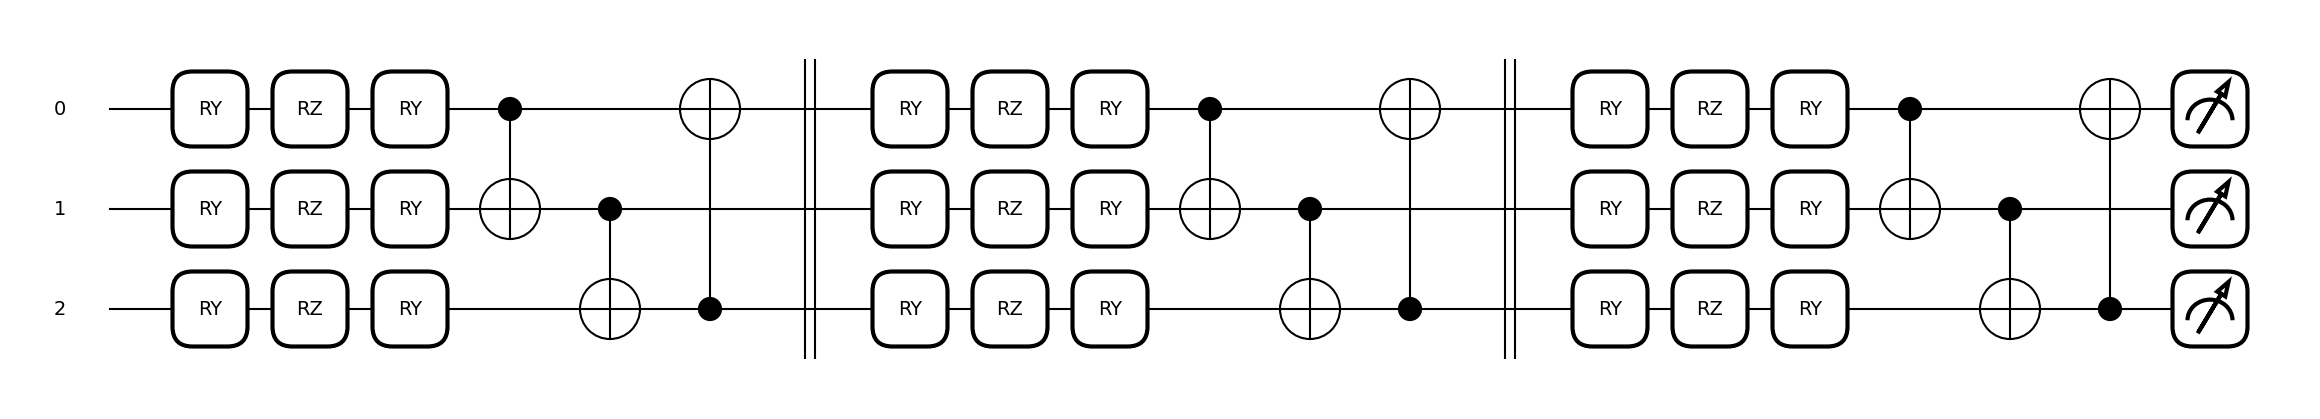

In [8]:
model = Model(
    n_qubits=3,
    n_layers=2,
    circuit_type="Hardware_Efficient",
    trainable_frequencies=True,
)
model.draw(figure="mpl")
initial_params = model.params
initial_theta_F = model.theta_F

In [3]:
qml.math.requires_grad(model.theta_F)  # Returns True or False


True

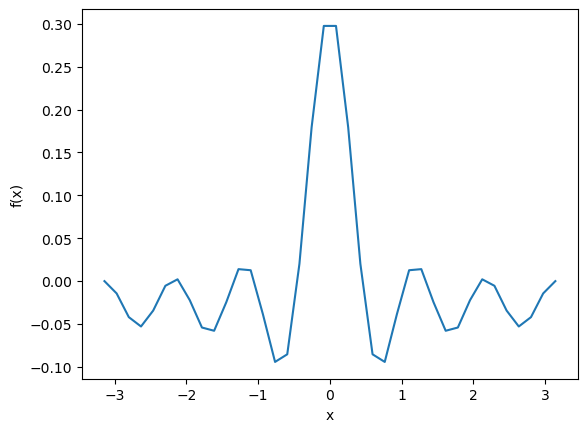

In [4]:
# - Toy Data -
domain = [-np.pi, np.pi]
omegas = np.array([1, 2, 3, 4, 5, 6])
coefficients = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

# Calculate the number of required samples to satisfy the Nyquist criterium
n_d = int(np.ceil(2 * np.max(np.abs(domain)) * np.max(omegas)))
# Sample the domain linearly
x = np.linspace(domain[0], domain[1], num=n_d)

# define our Fourier series f(x)
def f(x):
    return 1 / np.linalg.norm(omegas) * np.sum(coefficients * np.cos(omegas.T * x))

# evaluate f(x) on the domain samples
y = np.stack([f(sample) for sample in x])

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

Epoch: 100, Cost: 0.00352
Epoch: 200, Cost: 0.00252
Epoch: 300, Cost: 0.00044


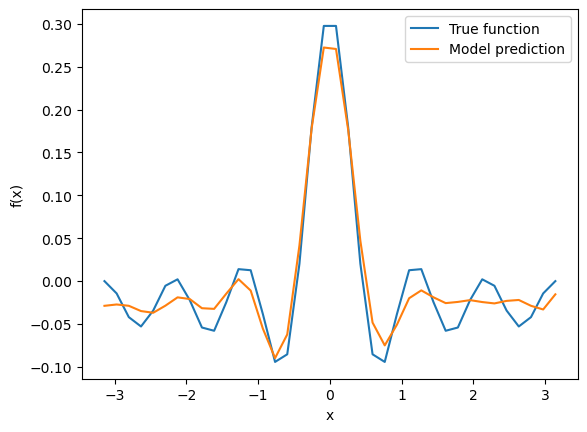

In [9]:
opt = qml.AdamOptimizer(stepsize=0.01)

# Save original shapes
param_shape = model.params.shape
theta_F_shape = model.theta_F.shape

# Initialize optimizer with packed parameters
vec = model.pack(model.params, model.theta_F)

def cost_fct(vec):
    params, theta_F = model.unpack(vec, param_shape, theta_F_shape)
    y_hat = model(params=params, theta_F=theta_F, inputs=x, force_mean=True)
    return np.mean((y_hat - y) ** 2)

for epoch in range(1, 301):
    vec, cost_val = opt.step_and_cost(cost_fct, vec)
    model.params, model.theta_F = model.unpack(vec, param_shape, theta_F_shape)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Cost: {cost_val:.5f}")


plt.plot(x, y, label="True function")
plt.plot(x, model(params=model.params, theta_F=model.theta_F, inputs=x, force_mean=True), label="Model prediction")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

In [6]:
grad_fct = qml.grad(cost_fct)

grads = grad_fct(vec)
print("Gradients shape:", grads.shape)
print("Gradients:", grads)

Gradients shape: (20,)
Gradients: [-3.61615634e-05  1.81799006e-06  2.82546791e-05 -3.86038556e-05
  1.27330579e-04  3.93520300e-05 -7.81935177e-05 -4.24692071e-05
 -1.32143002e-04  2.13851027e-04 -5.57878675e-05 -9.01122023e-06
  7.42138430e-05 -3.56821766e-05  9.79609777e-05  9.03234846e-06
  8.78800554e-06  4.44754495e-05 -2.66624174e-05 -1.83389907e-04]


In [10]:
print(initial_params)
print(model.params)
print()
print(initial_theta_F)
print(model.theta_F)

[[3.27596321 3.79405022 2.95901458 1.27704449 3.32229094 1.20031635
  1.76900317 4.73552086 3.466256  ]
 [5.42692586 5.06030291 1.56057147 1.1929093  6.18262658 4.20971635
  1.76169728 1.28122464 3.92739725]
 [4.10043385 5.64737426 6.12462146 0.9671856  4.39250746 2.81010089
  0.11003874 1.82856341 2.39538027]]
[[ 3.15176428  3.20996972  2.64955479  1.61016417  3.54129344  0.87027749
   1.423926    5.11313381  3.28907704]
 [ 6.08938766  5.33352705  1.36672262  1.33344041  6.46372278  4.47529144
   2.13530266  1.84057636  3.35889855]
 [ 3.88875724  5.39146845  5.73092603  0.75021625  4.53707197  3.04864687
  -0.07616274  1.47178235  2.04805865]]

[1. 1. 1.]
[1.35383668 1.29608519 1.33277551]
